<a href="https://www.kaggle.com/code/kaiyoo88/tutorial-pytorch-wikidocs?scriptVersionId=238685413" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
pip install konlpy -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt #Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

## 1. 데이터 전처리

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7d82c830ece0>)

In [7]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [8]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

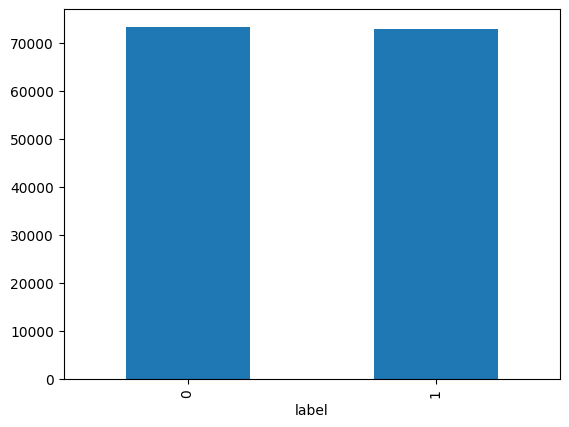

In [10]:
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [12]:
print(train_data.isnull().values.any())

True


In [13]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [14]:
condition = train_data.document.isnull()
train_data.loc[condition]

,id,document,label
25857,2172111,NaN,1


In [15]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [16]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [17]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipykernel_30/3966077745.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [18]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [19]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipykernel_30/2256962620.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [24]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [21]:
okt = Okt()

In [22]:
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [20]:
pip install soynlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 7.1 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [26]:
from soynlp.tokenizer import LTokenizer
tokenizer = LTokenizer()

In [27]:
X_train = []
for sentence in tqdm(train_data['document']):
    # tokenized_sentence = okt.morphs(sentence) # 토큰화
    tokenized_sentence = tokenizer.tokenize(sentence)

    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [00:04<00:00, 35176.25it/s]


In [28]:
X_test = []
for sentence in tqdm(test_data['document']):
    # tokenized_sentence = okt.morphs(sentence) # 토큰화
    tokenized_sentence = tokenizer.tokenize(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:01<00:00, 31254.23it/s]


In [29]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [30]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


In [31]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 251785


In [32]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 14126
훈련 데이터에서의 단어 공감의 등장 횟수 : 79


In [33]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '너무', '정말', '진짜', '왜', '이런', '그냥', '더', '수', '영화를']


In [34]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 251785
등장 빈도가 2번 이하인 희귀 단어의 수: 218307
단어 집합에서 희귀 단어의 비율: 86.70373532974561
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 27.314295691530795


In [35]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 33478


In [36]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [37]:
for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

In [38]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 33480


In [40]:
# 예시: word_to_index = {'이': 2, '영화': 3, '재미있다': 4, ...}

with open('word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)

In [ ]:
# 6) 정수 인코딩
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [ ]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [ ]:
for sent in encoded_X_train[:2]:
  print(sent)

In [ ]:
# Example:
# word_to_index = {
#     "나": 54,
#     "는": 40,
#     "행복": 25,
#     "하다": 72
# }

# index_to_word = {
#     54: "나",
#     40: "는",
#     25: "행복",
#     72: "하다"
# }

# 모델이 예측: [54, 40, 25, 72]
# =========>  ["나", "는"]

In [ ]:
# 디코딩
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [ ]:
encoded_X_train[0]

In [ ]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 28
below_threshold_len(max_len, X_train)

In [ ]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

In [ ]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

In [ ]:
print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

In [ ]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

In [ ]:
import numpy as np

# 데이터를 .npz 파일로 저장
np.savez('/kaggle/working/padded_data.npz', 
         padded_X_train=padded_X_train, 
         padded_X_valid=padded_X_valid, 
         padded_X_test=padded_X_test, 
         y_train=y_train, 
         y_valid=y_valid, 
         y_test=y_test)

In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('padded_data.npz')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)


## 2. LSTM을 이용한 네이버 영화 리뷰 분류 모델

In [ ]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits


In [ ]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)


In [ ]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))


In [ ]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)


## 3. 평가 코드 작성

In [ ]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


In [ ]:
# n_epochs = 1000

# for epoch in n_epochs:
#     train:
#      1) 모델_예측 = model(train_X)
#      2) 오차(loss) = criterion(모델_예측, 정답_train)
#      3) backpropagation: loss.backward()
#      4) 파라미터 업데이트: optimizer.step()

#     validation: 
#      1) 모델_예측 = model(valid_X)
#      2) 80% = 정확도_구하기(모델_예측, 정답_val)
    

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


## 4. 학습

In [ ]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


## 5. 모델 로드 및 평가

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

In [ ]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


## 6. 모델 테스트

In [ ]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    # tokens = okt.morphs(text) # 토큰화
    tokens = tokenizer.tokenize(text)
    
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


In [ ]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)


In [ ]:
test_input = "이딴게 영화냐 ㅉㅉ"
predict(test_input, model, word_to_index, index_to_tag)


In [ ]:
test_input = "감독 뭐하는 놈이냐?"
predict(test_input, model, word_to_index, index_to_tag)


In [ ]:
test_input = "와 개쩐다 정말 세계관 최강자들의 영화다"
predict(test_input, model, word_to_index, index_to_tag)
